# IFT3700 Devoir 2

## Question 1 (30%)

Imaginez que vous devez traiter des données de nature astronomique. Il s’agit de données sous forme de table concernant 7300 milliards d’étoiles. 

Pour chaque étoile la table contient la position dans l’espace 3D (3 FLOAT64), la luminosité apparente de l’étoile (1 FLOAT32) et sa catégorie représentée par un entier entre 1 et 10 (1 INT8) et un vecteurs de 23 caractéristiques physiques (23 FLOAT32). La taille des données qui sont stockées de façon efficace dépasse le 900 Téraoctets. 

Les données sont réparties de façon balancée sur 1200 serveurs avec un  processeur rapide, 128 Gigaoctets de mémoire vive et utilisant chacun un disque SSD de capacité 4 Téraoctets et de vitesse de lecture et écriture de 3 Gigaoctets/sec. La communication entre les serveurs s'effectue à une vitesse de 1 Gigaoctets/sec. 


Proposez une approche distribuée qui permet de répondre aux questions suivantes et expliquez en détail toute la démarche permettant leur résolution.

### **A.** Trouvez les 1000 paires d’étoiles les plus proches en termes de distance euclidienne.[Recherche des deux points les plus rapprochés](https://fr.wikipedia.org/wiki/Recherche_des_deux_points_les_plus_rapproch%C3%A9s)


[indice pour plus tard](https://sites.cs.ucsb.edu/~suri/cs235/ClosestPair.pdf) 

Premier brain storm : 

Avant de proposer un algorithme, essayons de trouver un moyen efficace de résoudre ce problème. 

Pour une visualistion simple, représentons à quoi peut ressembler un serveur qui contient des données sur les étoiles: 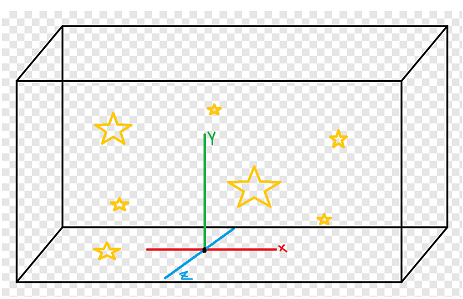

Pour le moment, oublions les autres serveurs et concentrons nous sur un seul uniquement. Une question se pose alors. Est-ce que les étoiles (Leurs positions dans l'espace 3D (x,y,z) pour être plus précis) sont triées dans l'ordre. Si oui, alors une partie du travail est faite. Puisque ce n'est pas précisé, nous allons assumer que non.

Nous n'allons pas proposer d'algorithme de tri détaillé, puisque ce n'est pas pertinant. Cela dit, tous les serveurs peuvent trier leurs étoiles parallèlement en **T(n) = O(n log(n))**, [ce qui correspondant au temps que peut prendre les meilleurs algorithmes de tri](https://fr.wikipedia.org/wiki/Algorithme_de_tri) .

À noter qu'un serveur a une capacité de 4Téra, mais que seulement 750 GO occupe cette capacitée soit 18,75% est occupée.
<br> Le calcul est comme suit : *( ( 900 Tera * 1000) GO / 1200 Serveurs)*. Cela fait que notre tri en parrallèle va bien se passer puisque nous pouvions déplacer nos étoiles dans le serveur sans aucun problème. 

Maintenant, il est intéressant de se demander comment utiliser MapReduce. 


Assumons pour le moment que tout s'est bien passé et que nous avions trié avec succès nos étoiles dans un ordre croissant. Il est maintenant plus simple dans un serveur d'utiliser un algorthime [divide and conquer](https://en.wikipedia.org/wiki/Divide-and-conquer_algorithm). Pourquoi ce type d'algorithme ? C'est pour séparer le gros problème en plus petits sous-problème et tous les résoudres parallèlement pour enfin avoir une réponse finale à notre gros problème. 

Dans notre cas, la solution brute aurait été de comparer chaque étoile à toutes les autres étoiles O(n^2) pour trouver les distances les plus courtes (soit les paires les plus proches). Ce qui est inconcevable vu la taille de notre échantillon. Donc , si on dévise efficacement notre problème, on peut réduire le O(n^2) jusqu'à O(n log n) , ce qui est beaucoup mieux. Nous allons maintenant expliquer comment procéder.

Encore une fois, pour un but d'illustration, travaillons pour le moment sur un seul serveur. Comment un serveur peut-t-il s'y prendre pour retourner la paire d'étoiles les plus proches ? Car oui, pour le moment essayons d'abord de trouver la paire d'étoiles la plus proches avant d'essayer d'en trouver 10. 

On pourrait croire que la division de l'espace récursive dans l'approche que nous allons proposer va saturer la mémoire vive vu l'immense taille de notre échantillon. Cela dit, il n'y pas de risque puisque nous allons garder en mémoire seulement les plans qui séparent l'espace et les paires d'étoiles les plus intéressantes. Le reste au besoin , nous allons directement le lire dans le disque dur. 


Par la division de l'espace avec des plans, nous sous-entendons tout simplement créer un plan qui sépare l'espace 3D comme suit: 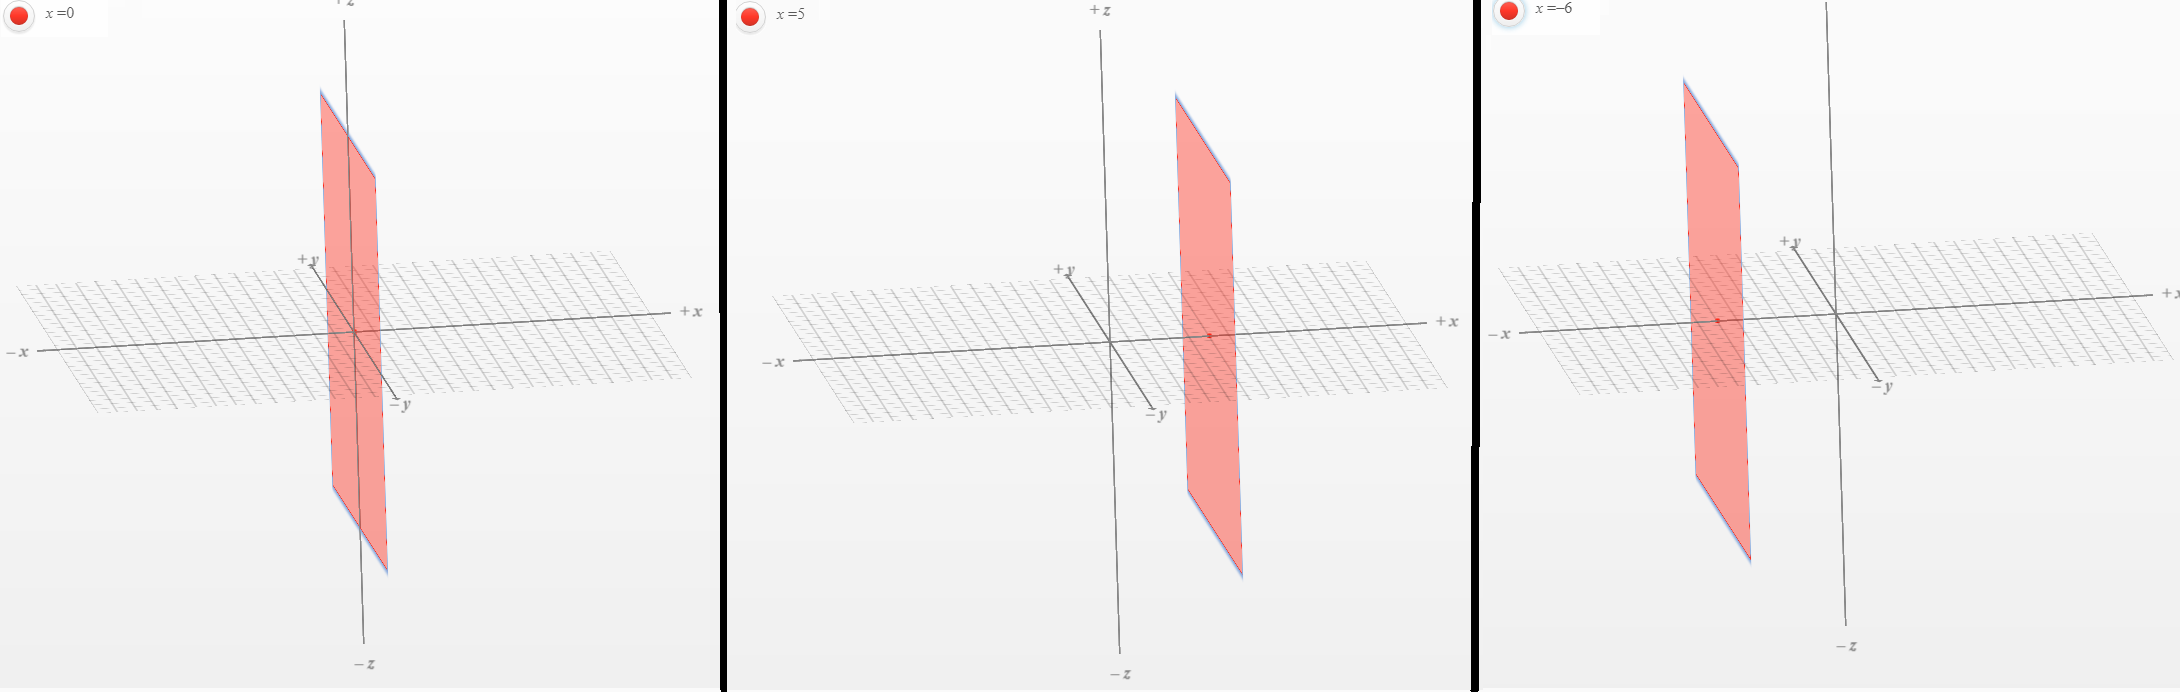 


Ainsi, nous pouvions proposer une première approche [indice](https://youtu.be/ldHA8UcQI9Q) :


**TrouverPaire** ( V : [VecteursPositionsÉtoiles_Trié] ) : 

    
    1. int D <- ( V[premier Element].getX + V[dernier Element].getX ) / 2 (Possible de deviser mieux qu'au milieu?) 
    
    2. plane <- x = D  
    
    3. Déviser V selon plane
    
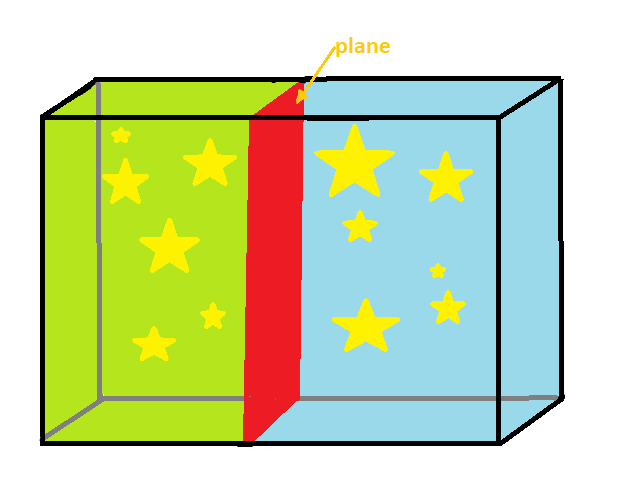
    

    B -> Case de base : return paire plus proche (distance euclidienne)  points des deux-sous plans 
    
    R -> Récursivement deviser les deux sous-espaces. 
    
    
Biensûre , il est important de noter que : Si S est la distance de la paire d'étoiles les plus proches dans le premier sous-espace et S' la distance de la paire la plus proches du deuxième sous-espace, alors return min(S , S') n'est pas suffisant.
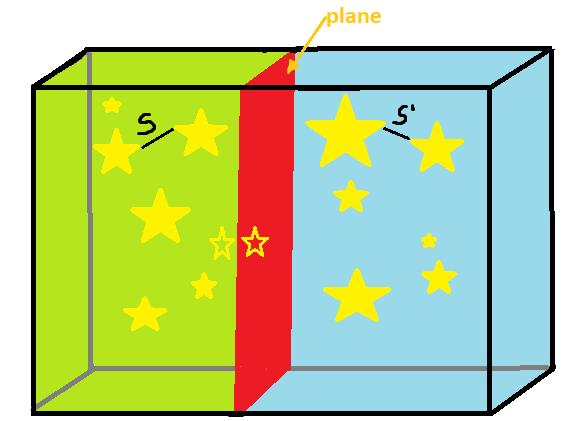 


En effet, il est possible qu'une étoile (p) du premier sous-espace et une étoile (d) du deuxième souce-espace forme une paire avec une distance S'' inférieure à min(S , S') . Autrement dit distance(p,d) = S'' et S'' < min(S, S').  
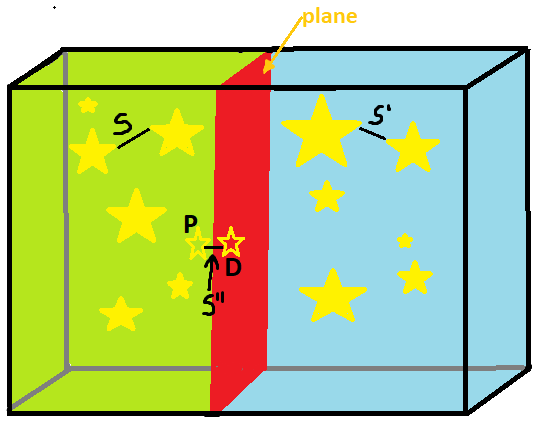


Comment faire pour trouver cette paire si elle existe ? Comparer chacunes des étoiles du premier sous-espace aux étoiles du deuxième sous-espace nous rammène à notre problème initiale (Brute Force O(n^2)). Heureusement , nous n'avions pas à le faire puisque que la distance S'' doit être plus petite que min(S, S'). Donc, puisque nous avions préablement trié notre espace, nous avions à regarder seulement à une distance de min(S, S') du plane. Illustrons nos propos : 

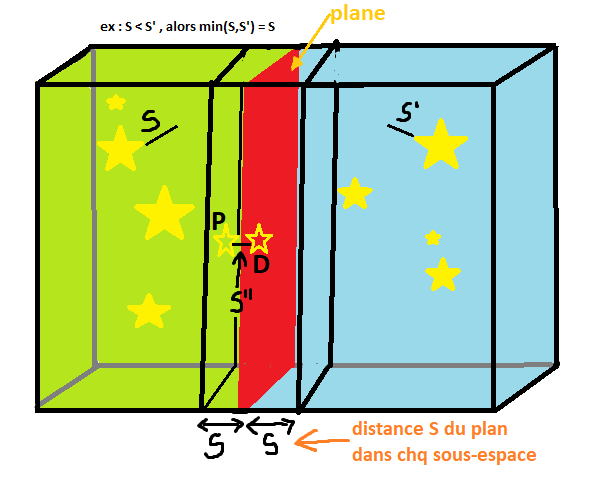


De plus, il est possible que ce dernier sous-espace ( -S | plane | S+ ) contienne un très grand nombre d'étoiles. Sommes-nous tous obligés de les comparer entres elles ? La réponse est heureusement non. Nous pouvons tout simplement répéter le même raisonnement. 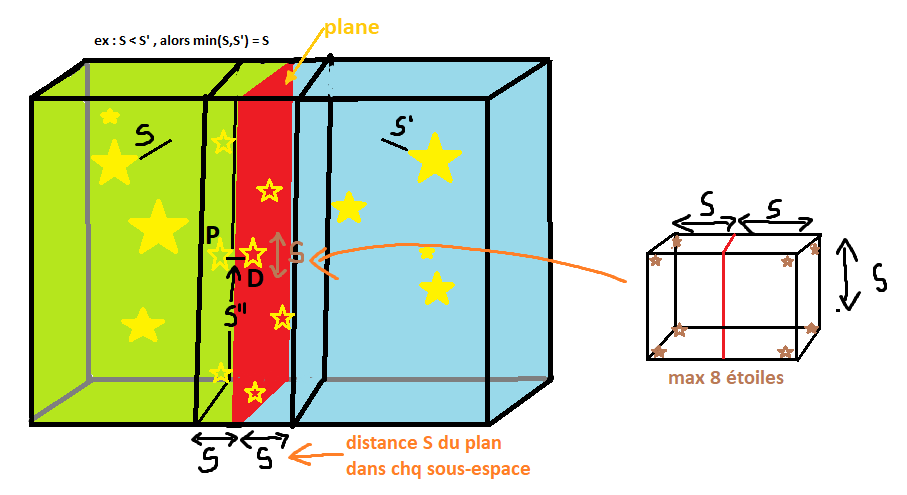 

Donc, en parcourant sur l'axe des y cette fois de haut en bas, pour chaque étoile O(n) , il suffit de regarder dans le rayon S*2 : S (voir image plus haut) O(1) s'il existe une autre étoile. Si oui, alors sa distance vers cette étoile est nécessairement plus petite que ce que nous avions trouvé précedemment et on met donc à jour notre min. 


Faisons ainsi , cet algorithme va retourner pour le serveur la paire la plus proche. Bien entendu , l'optimale pour nous c'est d'en trouver 10. Il suffit alors tout simplement de garder en mémoire dans un tableau 10 paires d'étoiles plutôt qu'une seule. 
Autrement dit : 


**TrouverPaire** ( V : [VecteursPositionsÉtoiles_Trié] , Solution : [paires Étoiles] ) : 

    
    1. int D <- ( V[premier Element].getX + V[dernier Element].getX ) / 2 (Possible de deviser mieux qu'au milieu?) 
    
    2. plane <- x = D  
    
    3. Déviser V selon plane
 
    B -> Case de base : ajouter nouvelle paire plus proche points des deux-sous plans à [Solution] si : 
        
        length ( Solution ) < 10  ou nouvelle paire < toutes les paires dans Solution 
        Note : supprimer paire avec plus grand distance si len(Solution) > 10 avec l'ajout
        
    R -> Récursivement deviser les deux sous-espaces. 



Si nous faisons cela pour tous nos serveurs parallelement et on assumons que ca marche, alors chacun de nos serveurs aura trouver 10 paires d'étoiles les plus proches. Rapidement comme ca , on peut se dire que cela ne nous pas avancé de beaucoup puisque 10 paires d'étoiles pour chaque serveurs , on se retrouve à 10 * 1200 = 12 000 paires d'étoiles. Pourtant cela nous a avancé. Il est temps de voir les choses sous l'angle du map reduce. 

Prenons le temps de regarder cette image de la dernière démo : 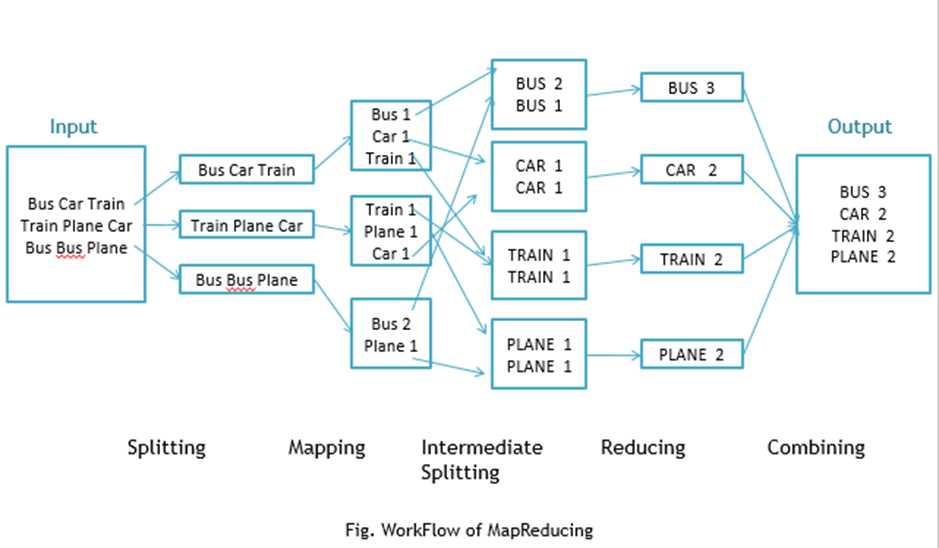

Il est clair que le input et le splitting a déjà était fait sur nos serveurs. Cela dit pour le reste pas encore. Mais avant de sauter au code, voyons les choses comme suit: 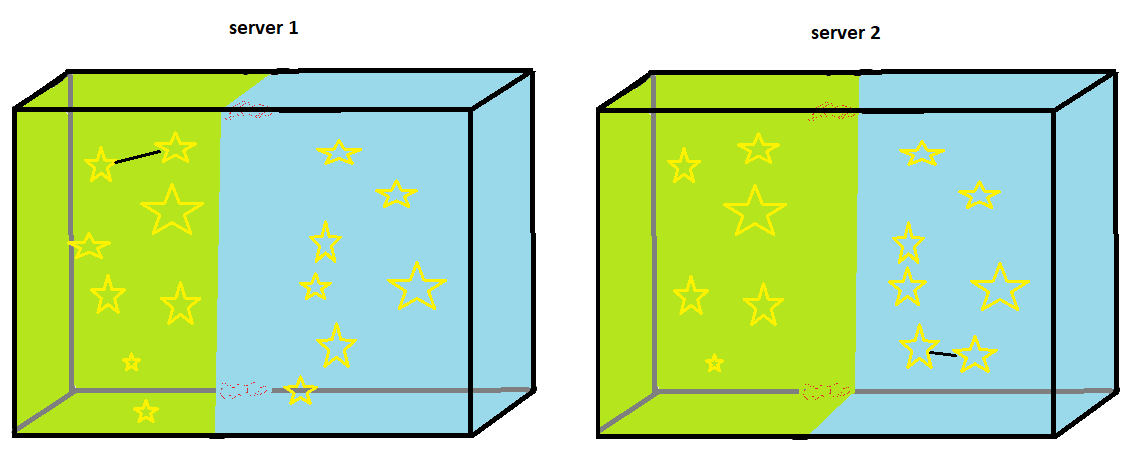

Ca ne vous rappel pas quelque chose? Oui ca nous rappel notre espace que nous avions séparés en deux. Maintenant la différence, c'est que nous avions deux sous-espace , mais disons pas exactement séparés comme on le shouaite. Cela dit , nous savions pour chacuns des deux serveurs séparement quelles sont les 10 meilleures paires. Donc, mainteant , biensure , nous pouvons faire:

**Algo**( S1 : Server1[Solution] , S2: Server2[Solution]:
    1. S = S1 + S2 
    2. trier S en ordre croissant 
    3. return S[0..10] 
    
Mais ca serait une erreur. La même erreur qu'on aurait pu faire avant. En effet puisque il est fort possible qu'en comparant les deux serveurs, on découvre (comme avant) une paire d'étoile plus proches que tous ce que nous avons dans S. Biensûre encore une fois, impossible de comparer chacune des étoiles du premier serveur au deuxième serveur. Que pouvons nous faire ? 
 